In [1]:
#!/usr/bin/env python
#coding=utf-8

# K-means

### 優點：

    1. 算法框架清晰，簡單，容易理解；
    2. 本算法確定的ķ個劃分到達平方誤差最小。當分群是密集的，且類與類之間區別明顯時，效果較好；
    3. 對於處理大數據集，這個算法是相對可伸縮和高效的，計算的複雜度為 O (NKT)，其中N是數據對象的數目，t是迭代的次數。
       一般來說，K << N，t << N。
    
### 缺點：

    1. k（分群數）必須事先指定，其k值的選定是非常難以估計的；
    2. K均值需要人為地確定初始聚類中心，不同的初始聚類中心可能導致完全不同的聚類結果（可以使用k均值++算法來解決）；
    3. 運算時間開銷是非常大的；
    4. 對異常數據很敏感。在計算質心的過程中，如果某個數據很異常，在計算均值的時候，會對結果影響非常大。
    
### 算法改進

    針對上述第2個缺陷，可以使用Kmeans ++算法來解決。k-means++算法選擇初始種子的基本思想就是：初始的聚類中心之間的相互距離要進行的遠。如下：

        1. 從輸入的數據點集合中隨機選擇一個點作為第一個聚類中心；
        2. 對於數據集中的每一個點的x，計算它與最近聚類中心（指已選擇的聚類中心）的距離d(X)；
        3. 選擇一個新的數據點作為新的聚類中心，選擇的原則是：d(x)的較大的點，被選取作為聚類中心的概率較大；
        4. 重複2和3直到ķ個聚類中心被選出來；
        5. 利用這ķ個初始的聚類中心來運行標準的k均值算法。


參考資料：

https://blog.csdn.net/u011808673/article/details/81296623

https://www.cnblogs.com/hezhiyao/p/7390871.html

### klearn.cluster.KMeans:

##### sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001, precompute_distances=’auto’, verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm=’auto’)

預設方法： k-means++。

迭代次數：n_int = 10, max_iter=300，最低10次，最高300次。

參考資料：

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [1]:
# 能處理載入、整理與視覺化等常見的資料應用套件
import pandas as pd

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline

# 分群 K-means
from sklearn.cluster import KMeans

# 以 matplotlib 為基礎建構的高階繪圖套件，讓使用者更加輕鬆地建立圖表，可視為是 matplotlib 的補強。
import seaborn as sns

from sklearn.metrics import silhouette_score

import numpy as np

#計算欄位內元素的頻度
from collections import Counter

import os

In [2]:
os.getcwd()

'E:\\III\\III\\Workplace\\TopicProject\\DataProcessing'

#### 欄位名稱
品牌：Brand；
食物名：Name；
品牌+食物名：BraName；
食用量：Intake； 
熱量：Calories, Cal；
蛋白質：Protein； 
脂肪：Fat；
飽和脂肪：Saturated fatty acid, SF；
不飽和脂肪 as Unsaturated fat, USF；
多（元）飽和脂肪：Polyunsaturated fat, PUSF；
單（元）飽和脂肪：Monounsaturated fat, MUSF；
膽固醇：Total cholesterol, TC；
碳水化合物：Carbohydrate, CHO；
糖：Sugar； 
纖維：Fiber；
鈉：Na；
鉀：K；
資訊來源：Resource； 
更新時間：UpdateTime； 
反鏈脂肪：Trans fat,TF。

In [4]:
# 讀入 csv 文字檔
# 之前已經個資料庫檔案inner join的檔案
food_csv = "../Data/Food_Mixed2_test.csv"
dfi = pd.read_csv(food_csv, encoding='utf-8')

### 覽閱一下資料

In [5]:
dfi.head()

,Name,BraName,Intake_g,Cal_kcal,CHO_g,Fat_g,Protein_g,CHO_per,Fat_per,Protein_per,total_per
0,1％脂肪牛奶,_1％脂肪牛奶,1杯,102.0,12.18,2.37,8.22,53.491436,10.408432,36.100132,100.0
1,1％脂肪牛奶,_1％脂肪牛奶,1個（學生奶盒大小）（240 ml）,102.0,12.18,2.37,8.22,53.491436,10.408432,36.100132,100.0
2,1％脂肪牛奶,_1％脂肪牛奶,1份（244 g）,102.0,12.18,2.37,8.22,53.491436,10.408432,36.100132,100.0
3,1％脂肪牛奶,_1％脂肪牛奶,1標準一杯的份量，冷麥片,51.0,6.09,1.18,4.11,53.514938,10.369069,36.115993,100.0
4,1％脂肪牛奶,_1％脂肪牛奶,100 ml,43.0,5.15,1.00,3.48,53.478712,10.384216,36.137072,100.0


In [6]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24358 entries, 0 to 24357
Data columns (total 11 columns):
Name           24358 non-null object
BraName        24357 non-null object
Intake_g       24358 non-null object
Cal_kcal       24358 non-null float64
CHO_g          24358 non-null float64
Fat_g          24337 non-null float64
Protein_g      24349 non-null float64
CHO_per        24227 non-null float64
Fat_per        24227 non-null float64
Protein_per    24227 non-null float64
total_per      24227 non-null float64
dtypes: float64(8), object(3)
memory usage: 2.0+ MB


#### 刪除df_drink['BraName']重複值
```python
df = df.drop_duplicates(subset='BraName', keep='first') 
```
dataframe.drop_duplicates(subset='column', keep='first', inplace = False) 
<br>subset：以哪個欄位當主；keep：保留哪一值，{'first', 'last', 'False'（刪除所有重複）}, default 'first'；
<br>inplace : boolean, default False. Whether to drop duplicates in place or to return a copy

In [7]:
dfi = dfi.drop_duplicates(subset='BraName', keep='last') #取最後的，因為以官網為主，資料庫的資料為輔

#重整index
dfi = dfi.reset_index(drop=True)

dfi.head()

,Name,BraName,Intake_g,Cal_kcal,CHO_g,Fat_g,Protein_g,CHO_per,Fat_per,Protein_per,total_per
0,1％脂肪牛奶,_1％脂肪牛奶,1以30 ml為標準份量，飲料,1.0,0.12,0.02,0.08,54.545455,9.090909,36.363636,100.0
1,100％純楓樹糖漿,_100％純楓樹糖漿,1餐匙/湯匙,52.0,13.42,0.04,0.00,99.702823,0.297177,0.000000,100.0
2,100百份芒果味QQ糖,_100百份芒果味QQ糖,3 g,33.0,7.00,0.00,0.00,100.000000,0.000000,0.000000,100.0
3,17茶,_17茶,100 g,0.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN
4,2％脂肪牛奶,_2％脂肪牛奶,1以30 ml為標準份量，飲料,1.0,0.12,0.05,0.08,48.000000,20.000000,32.000000,100.0


In [8]:
# 補遺漏值
dfi = dfi.fillna(0)
dfi.head()

,Name,BraName,Intake_g,Cal_kcal,CHO_g,Fat_g,Protein_g,CHO_per,Fat_per,Protein_per,total_per
0,1％脂肪牛奶,_1％脂肪牛奶,1以30 ml為標準份量，飲料,1.0,0.12,0.02,0.08,54.545455,9.090909,36.363636,100.0
1,100％純楓樹糖漿,_100％純楓樹糖漿,1餐匙/湯匙,52.0,13.42,0.04,0.00,99.702823,0.297177,0.000000,100.0
2,100百份芒果味QQ糖,_100百份芒果味QQ糖,3 g,33.0,7.00,0.00,0.00,100.000000,0.000000,0.000000,100.0
3,17茶,_17茶,100 g,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.0
4,2％脂肪牛奶,_2％脂肪牛奶,1以30 ml為標準份量，飲料,1.0,0.12,0.05,0.08,48.000000,20.000000,32.000000,100.0


In [9]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12930 entries, 0 to 12929
Data columns (total 11 columns):
Name           12930 non-null object
BraName        12930 non-null object
Intake_g       12930 non-null object
Cal_kcal       12930 non-null float64
CHO_g          12930 non-null float64
Fat_g          12930 non-null float64
Protein_g      12930 non-null float64
CHO_per        12930 non-null float64
Fat_per        12930 non-null float64
Protein_per    12930 non-null float64
total_per      12930 non-null float64
dtypes: float64(8), object(3)
memory usage: 1.1+ MB


## K-means

In [10]:
# 製作執行k-means之dataframe
df_k = dfi[['CHO_per', 'Fat_per', 'Protein_per']] # 僅取百分比

# 檢視data
df_k.head()

,CHO_per,Fat_per,Protein_per
0,54.545455,9.090909,36.363636
1,99.702823,0.297177,0.000000
2,100.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,48.000000,20.000000,32.000000


In [11]:
df_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12930 entries, 0 to 12929
Data columns (total 3 columns):
CHO_per        12930 non-null float64
Fat_per        12930 non-null float64
Protein_per    12930 non-null float64
dtypes: float64(3)
memory usage: 303.1 KB


In [12]:
plt.style.use('ggplot')

df_k = df_k.values
df_k

array([[ 54.54545455,   9.09090909,  36.36363636],
       [ 99.70282318,   0.29717682,   0.        ],
       [100.        ,   0.        ,   0.        ],
       ...,
       [ 92.        ,   4.        ,   4.        ],
       [100.        ,   0.        ,   0.        ],
       [100.        ,   0.        ,   0.        ]])

#### 找出最佳分群數（k）

('K choice:', [2, 3, 4, 5, 6, 7, 8, 9])
('Score:', [0.5458715097238683, 0.4220818221044489, 0.4277951527332188, 0.4038899452277829, 0.40006832565073397, 0.4002406723824468, 0.4145173104793266, 0.4161188888340646])


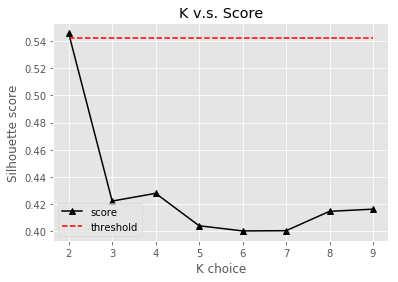

In [13]:
# 找出最佳分群數（k）
from sklearn.metrics import silhouette_score
x = []
y = []
for k in range(2, 10):
    cluster = KMeans(n_clusters=k)
    cluster.fit(df_k)
    s = silhouette_score(df_k, cluster.labels_)
    x.append(k)
    y.append(s)
print("K choice:", x)
print("Score:", y)

# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
threshold = [0.542] * len(x)
plt.title("K v.s. Score")
plt.xlabel("K choice")
plt.ylabel("Silhouette score")
p1, = plt.plot(x, y, "^-k", label="score")
p2, = plt.plot(x, threshold, "--r", label="threshold")
plt.legend(handles=[p1, p2])

# k = 2

In [14]:
param = 3
k = 2
Stand = 'Percentage'
path = '..\\Output\\DataAnalysis_food_Clustering_Kmeans_'

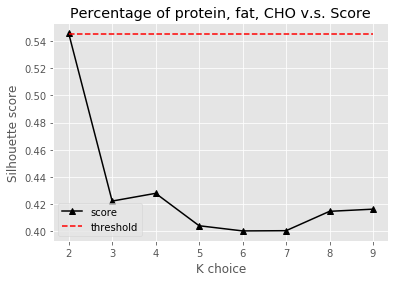

In [15]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
threshold = [0.545] * len(x)
plt.title("Percentage of protein, fat, CHO v.s. Score")
plt.xlabel("K choice")
plt.ylabel("Silhouette score")
p1, = plt.plot(x, y, "^-k", label="score")
p2, = plt.plot(x, threshold, "--r", label="threshold")
plt.legend(handles=[p1, p2])


# 儲存圖片
plt.savefig(path + Stand + '_' + str(param)+  'param' + '_KChoice'+ str(k) + '.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [16]:
cluster = KMeans(n_clusters=k)
cluster.fit(df_k)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
df_kmean = dfi
df_kmean["label"] = cluster.labels_

# 看一下df["label"]內元素的出現頻度
Counter(df_kmean["label"])

Counter({0: 9401, 1: 3529})

In [18]:
cluster.cluster_centers_

array([[75.71471696, 12.81262866, 11.47265438],
       [23.51122592, 33.18744111, 40.55189987]])

In [19]:
dfi.head()

,Name,BraName,Intake_g,Cal_kcal,CHO_g,Fat_g,Protein_g,CHO_per,Fat_per,Protein_per,total_per,label
0,1％脂肪牛奶,_1％脂肪牛奶,1以30 ml為標準份量，飲料,1.0,0.12,0.02,0.08,54.545455,9.090909,36.363636,100.0,0
1,100％純楓樹糖漿,_100％純楓樹糖漿,1餐匙/湯匙,52.0,13.42,0.04,0.00,99.702823,0.297177,0.000000,100.0,0
2,100百份芒果味QQ糖,_100百份芒果味QQ糖,3 g,33.0,7.00,0.00,0.00,100.000000,0.000000,0.000000,100.0,0
3,17茶,_17茶,100 g,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.0,1
4,2％脂肪牛奶,_2％脂肪牛奶,1以30 ml為標準份量，飲料,1.0,0.12,0.05,0.08,48.000000,20.000000,32.000000,100.0,1


In [19]:
# 存一下檔
dfi.to_csv(path + Stand + '_' + str(param)+  'param' + '_k' + str(k) +'.csv', encoding='utf-8', index=False)

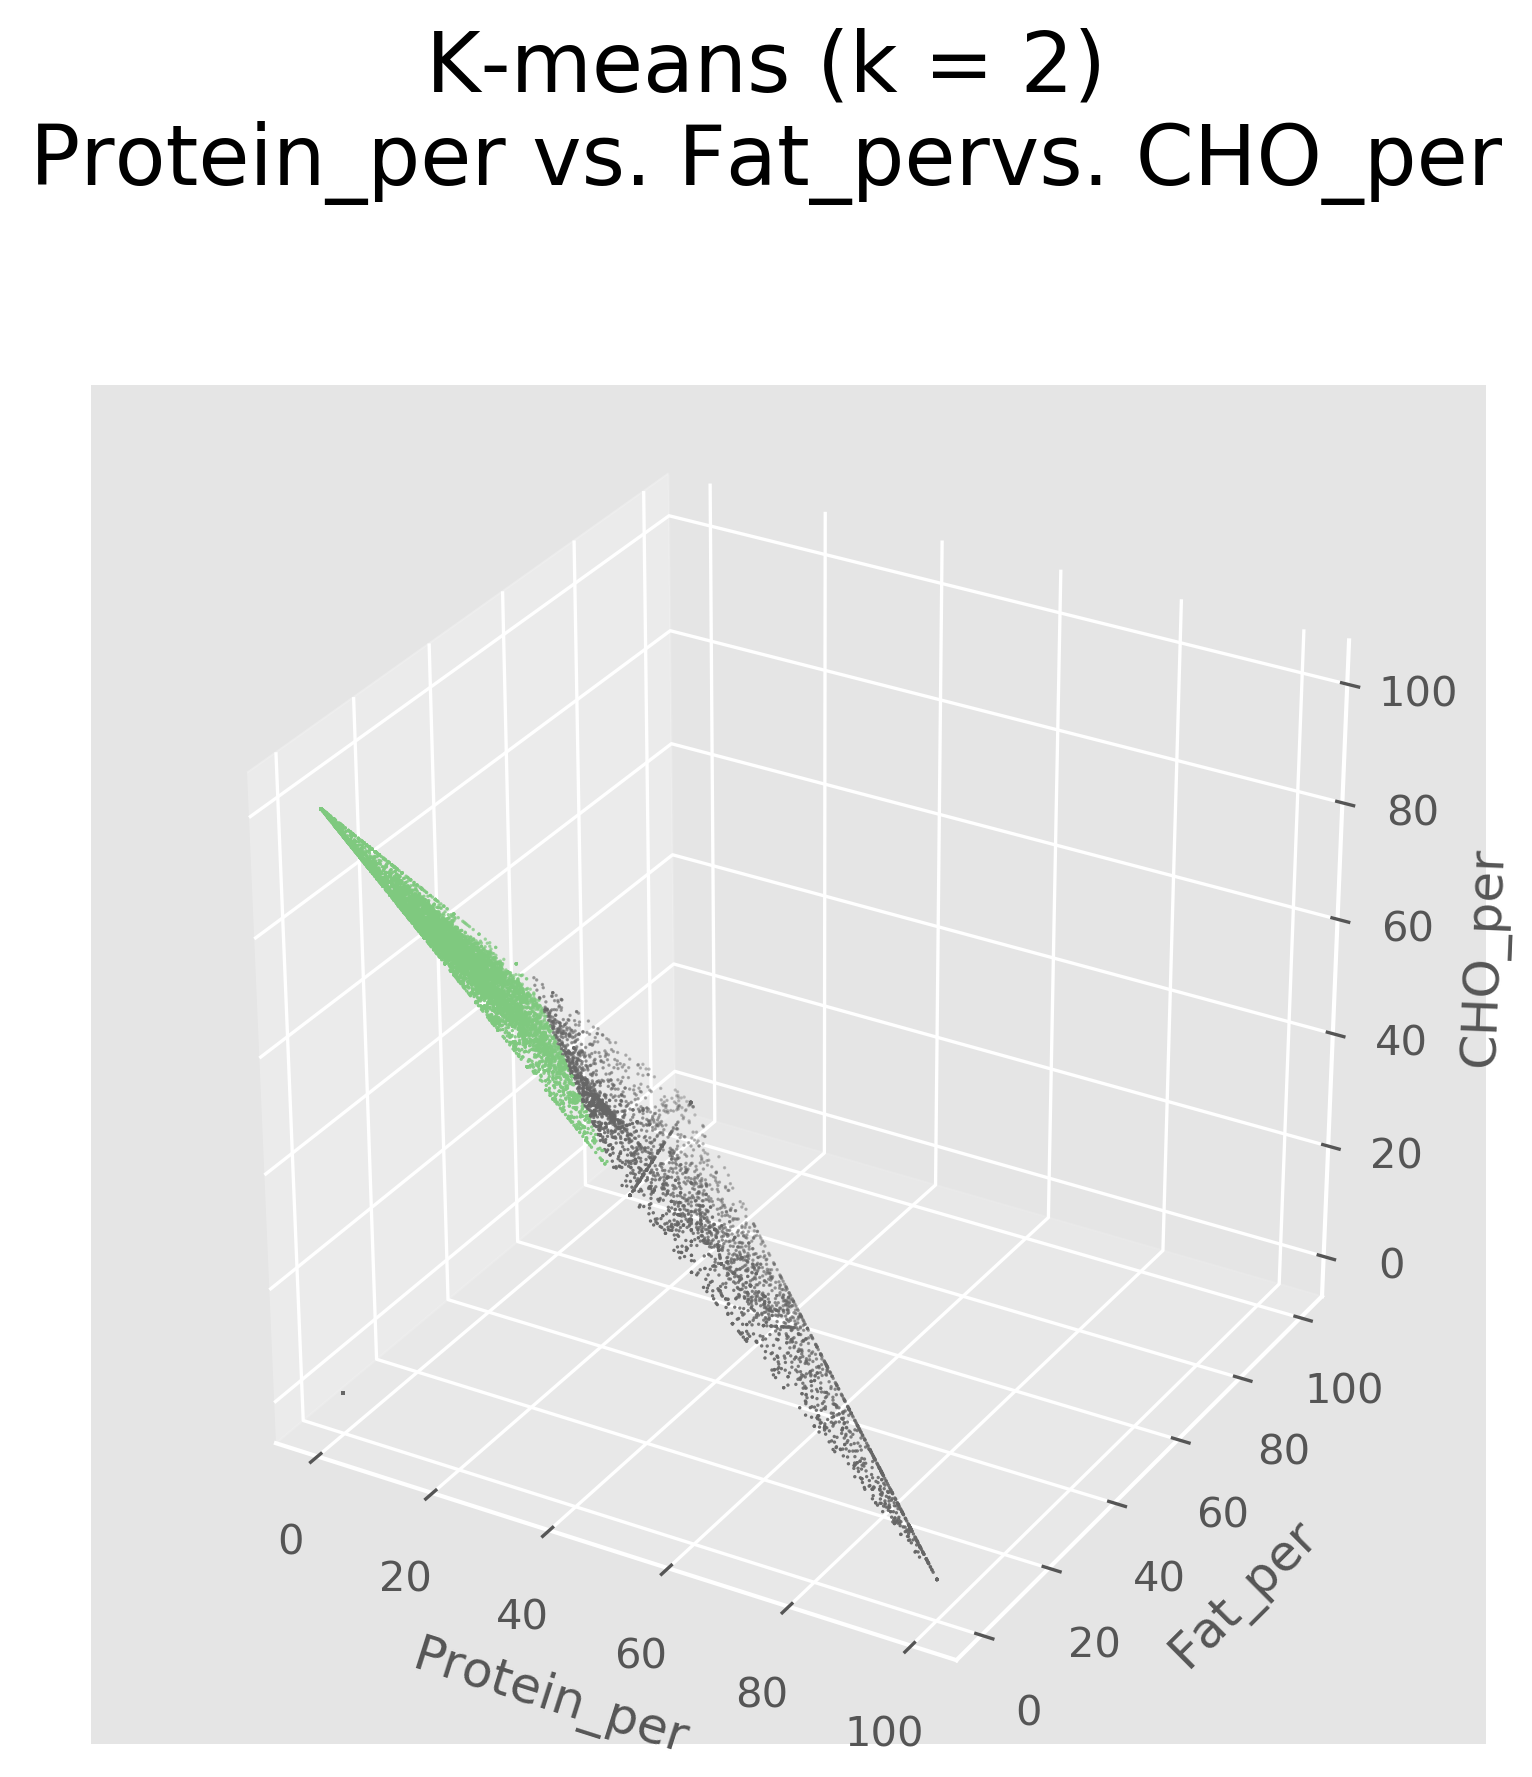

In [63]:
a = "Protein_per"
b = "Fat_per"
c = "CHO_per"

x=dfi[a]
y=dfi[b]
z=dfi[c]
hue=dfi["label"]

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 制訂畫布
plt.figure(num=None, figsize=(6, 6), dpi=300, facecolor='w', edgecolor='k')

# 制訂畫布抬頭
plt.suptitle("K-means (k = " + str(k)+ ")" + ('\n') + a + ' vs. ' + b +  'vs. '+ c, ha = 'center', va = 'bottom',
                 fontsize=20)

ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
#  将数据点分成三部分画，在颜色上有区分度
ax.scatter(x, y, z,  s=0.1, c=hue, cmap = 'Accent', linewidth = 0.5)  # 绘制数据点

ax.set_xlabel(a) # 坐标轴
ax.set_ylabel(b)
ax.set_zlabel(c)  

plt.show()


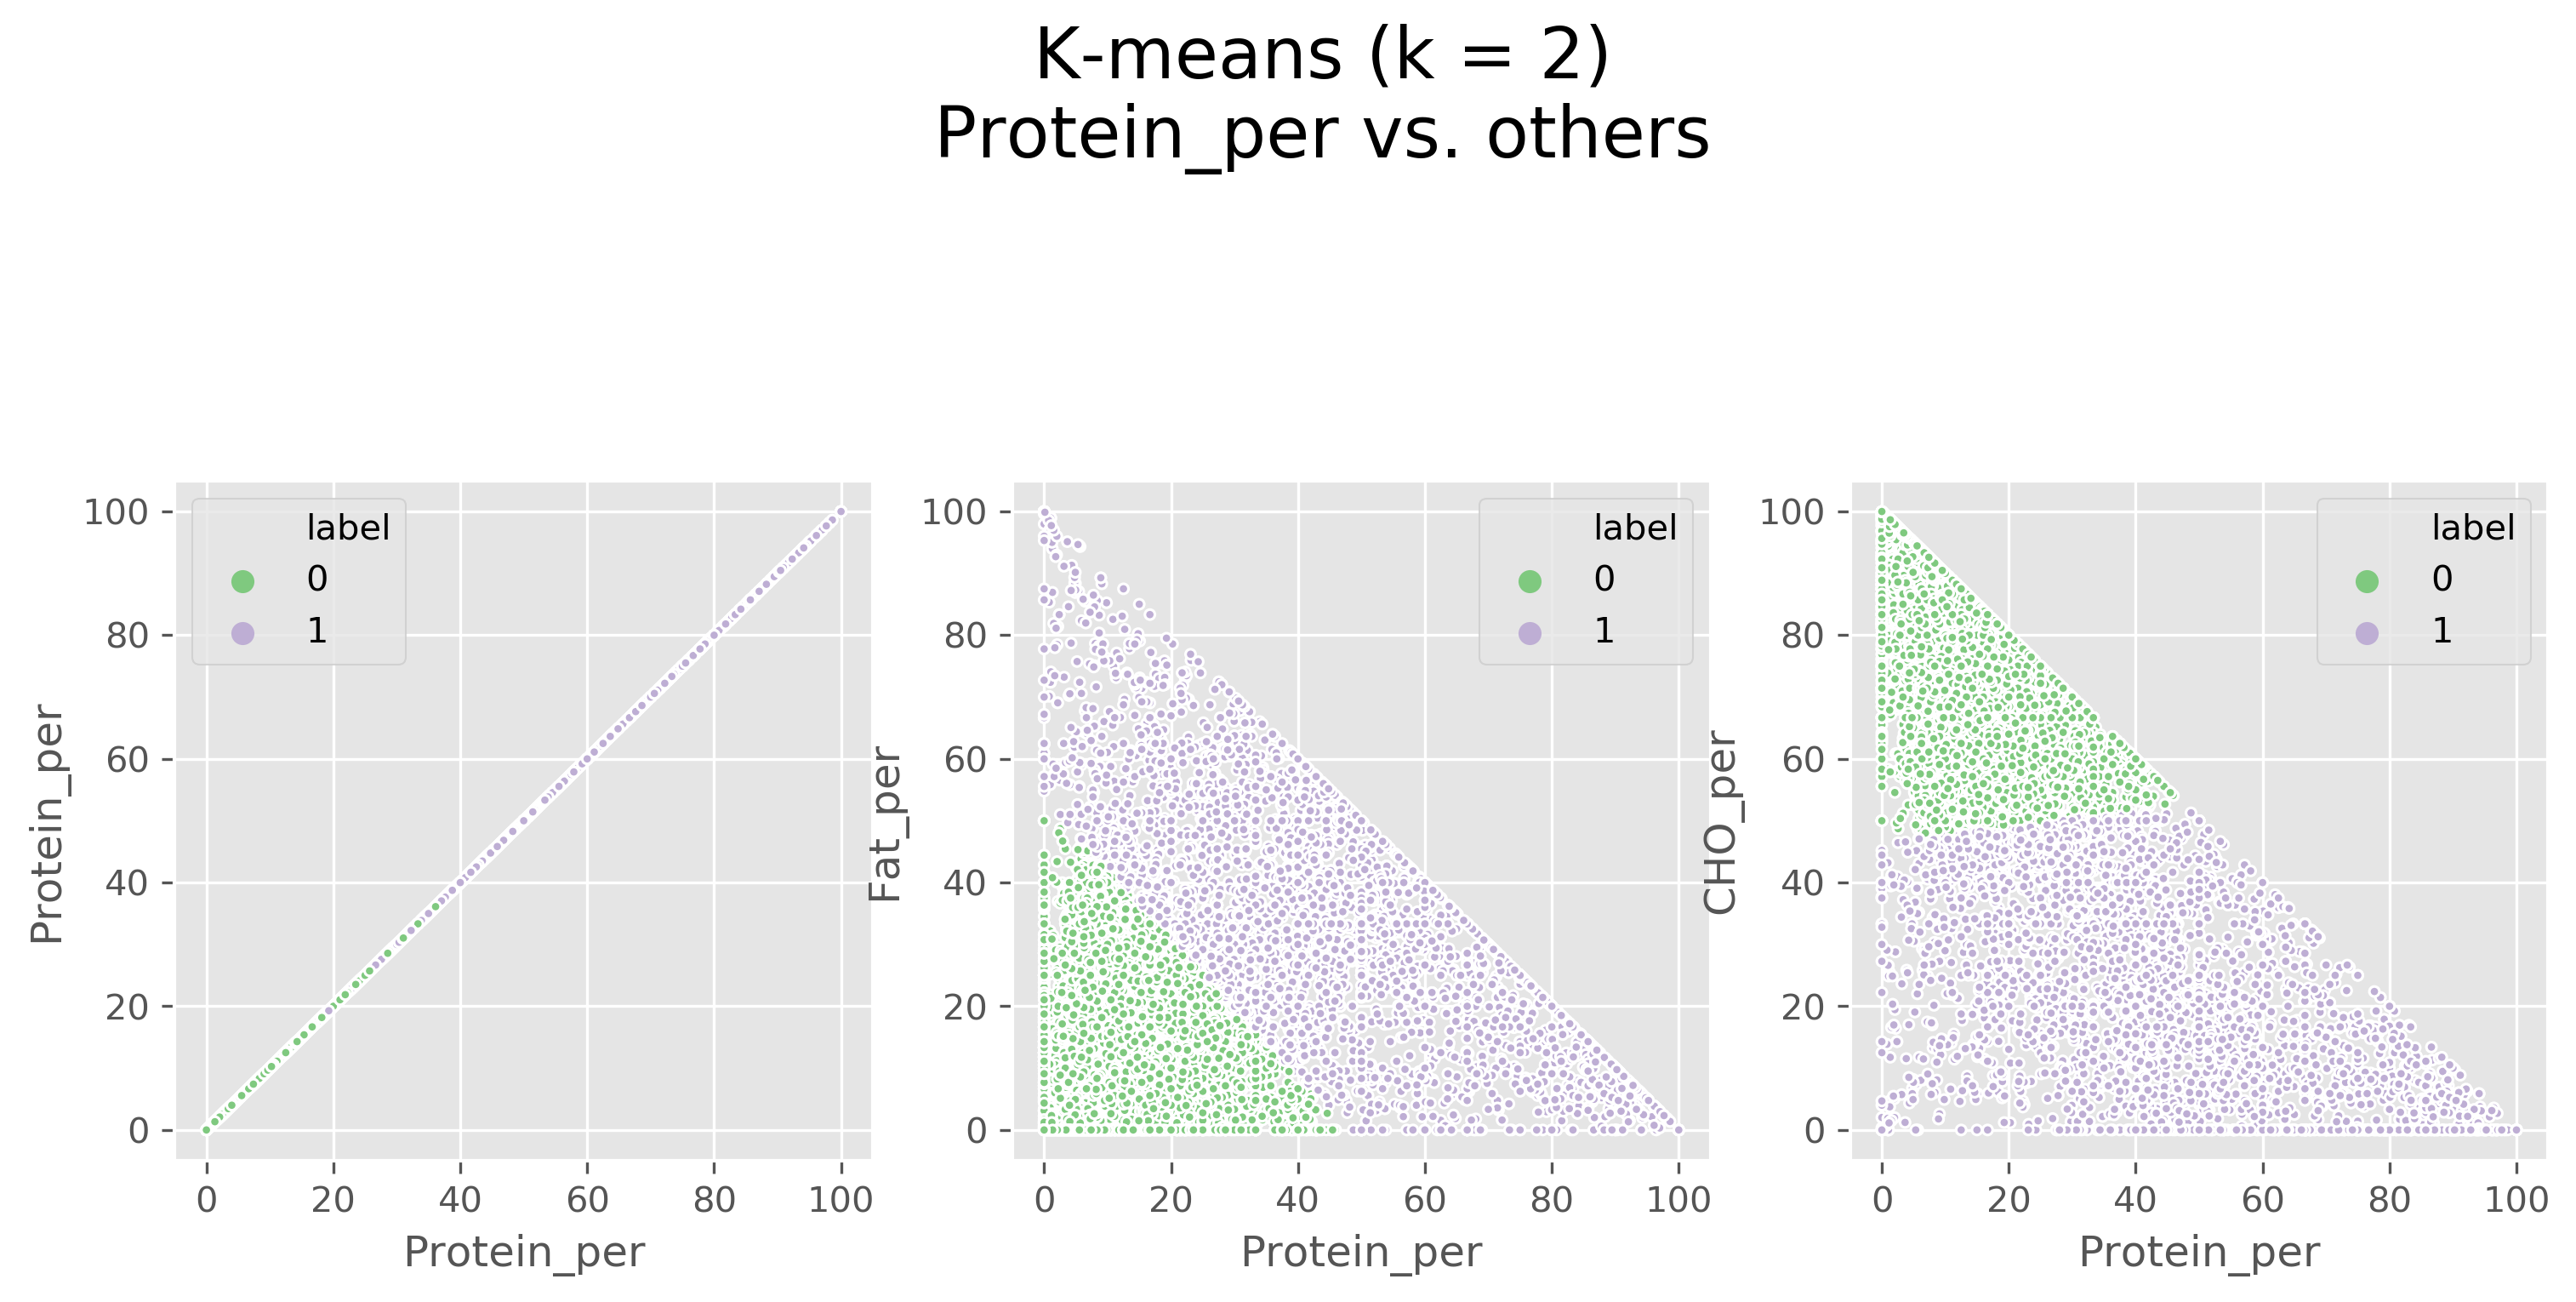

In [69]:
##Protein_per vs. others

title = 'Protein_per' 

a = "Protein_per"
b = "Fat_per"
c = "CHO_per"

# 制訂畫布
plt.figure(num=None, figsize=(12, 12), dpi=300, facecolor='w', edgecolor='k')

# 制訂畫布抬頭
plt.suptitle("K-means (k = " + str(k)+ ")" + ('\n') + title + ' vs. others', ha = 'center', va = 'bottom',
                 fontsize=20)

# 子圖
plt.subplot(3,3,1)
sns.scatterplot(x=dfi[title],
                y=dfi[a],
                hue=dfi["label"], palette="Accent", s=8)
 
plt.subplot(3,3,2)
sns.scatterplot(x=dfi[title],
                y=dfi[b],
                hue=dfi["label"], palette="Accent", s=8)
 
plt.subplot(3,3,3)
sns.scatterplot(x=dfi[title],
                y=dfi[c],
                hue=dfi["label"], palette="Accent",  s=8)

# 儲存圖片
plt.savefig(path + Stand + '_' + "k" + str(k)  +  '_' + str(param)+'param' + '_' + str(title) + 'VsOthers' +'.png', dpi=300, bbox_inches = 'tight')
plt.show()

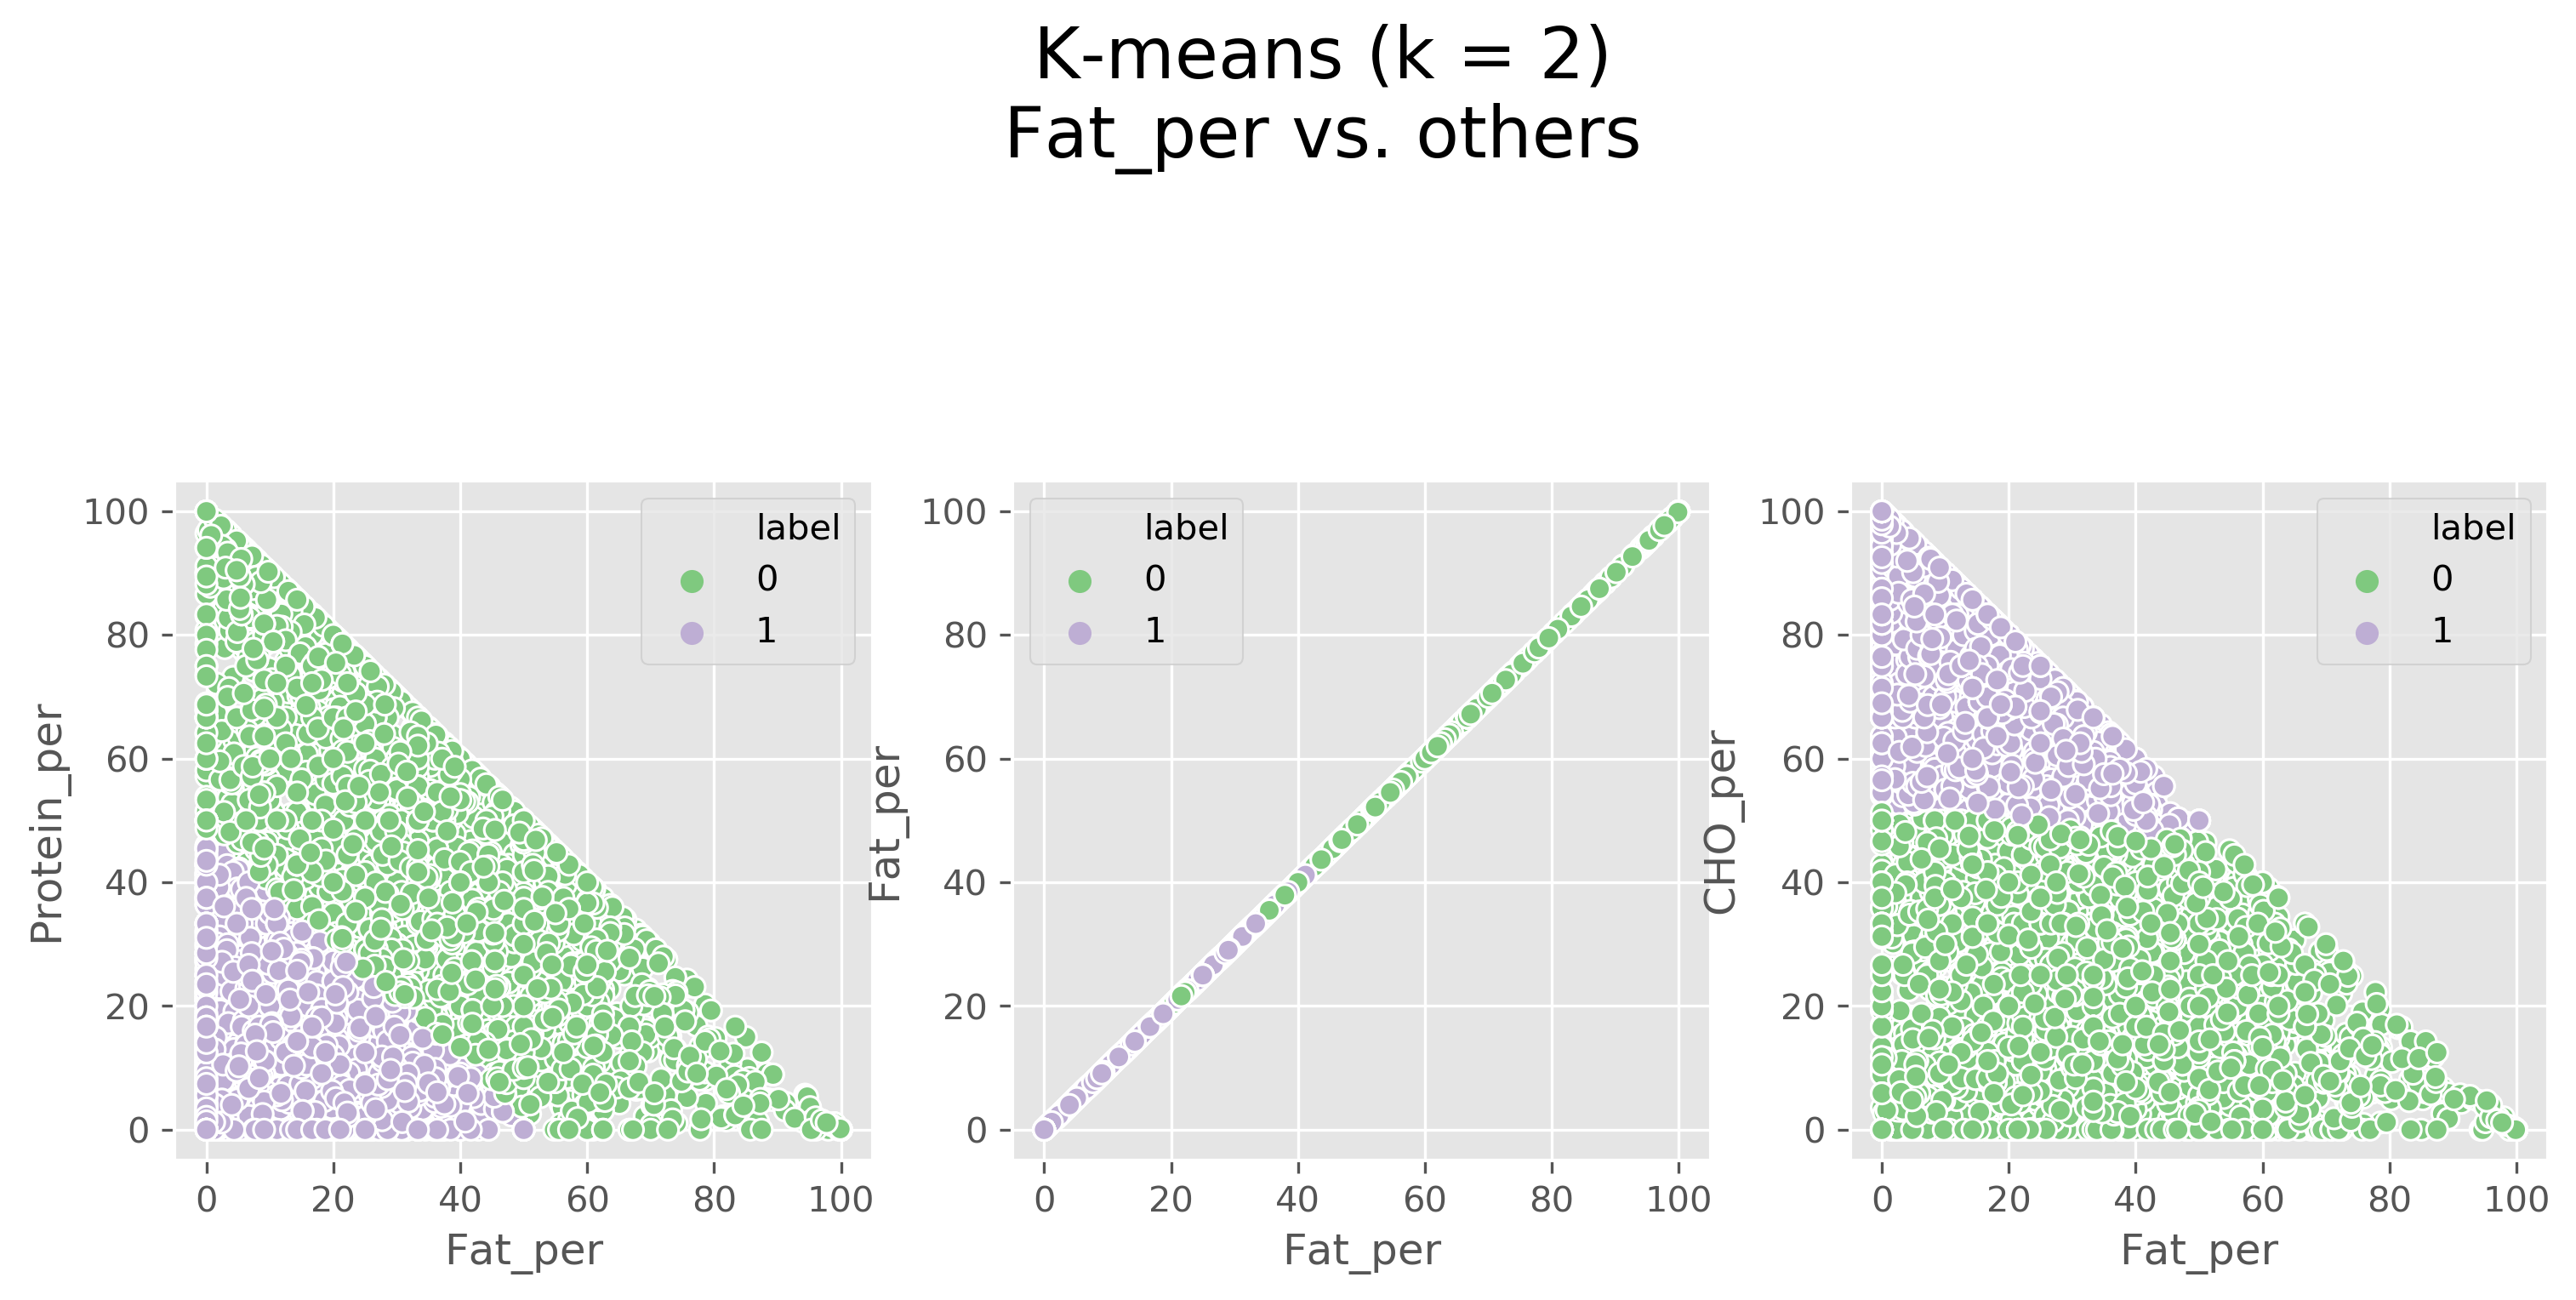

In [21]:
##Fat_per vs. others

title = 'Fat_per' 

a = "Protein_per"
b = "Fat_per"
c = "CHO_per"

# 制訂畫布
plt.figure(num=None, figsize=(12, 12), dpi=300, facecolor='w', edgecolor='k')

# 制訂畫布抬頭
plt.suptitle("K-means (k = " + str(k)+ ")" + ('\n') + title + ' vs. others', ha = 'center', va = 'bottom',
                 fontsize=20)

# 子圖
plt.subplot(3,3,1)
sns.scatterplot(x=dfi[title],
                y=dfi[a],
                hue=dfi["label"], palette="Accent")
 
plt.subplot(3,3,2)
sns.scatterplot(x=dfi[title],
                y=dfi[b],
                hue=dfi["label"], palette="Accent")
 
plt.subplot(3,3,3)
sns.scatterplot(x=dfi[title],
                y=dfi[c],
                hue=dfi["label"], palette="Accent")

# 儲存圖片
plt.savefig(path + Stand + '_' + "k" + str(k)  +  '_' + str(param)+'param' + '_' + str(title) + 'VsOthers' +'.png', dpi=300, bbox_inches = 'tight')
plt.show()

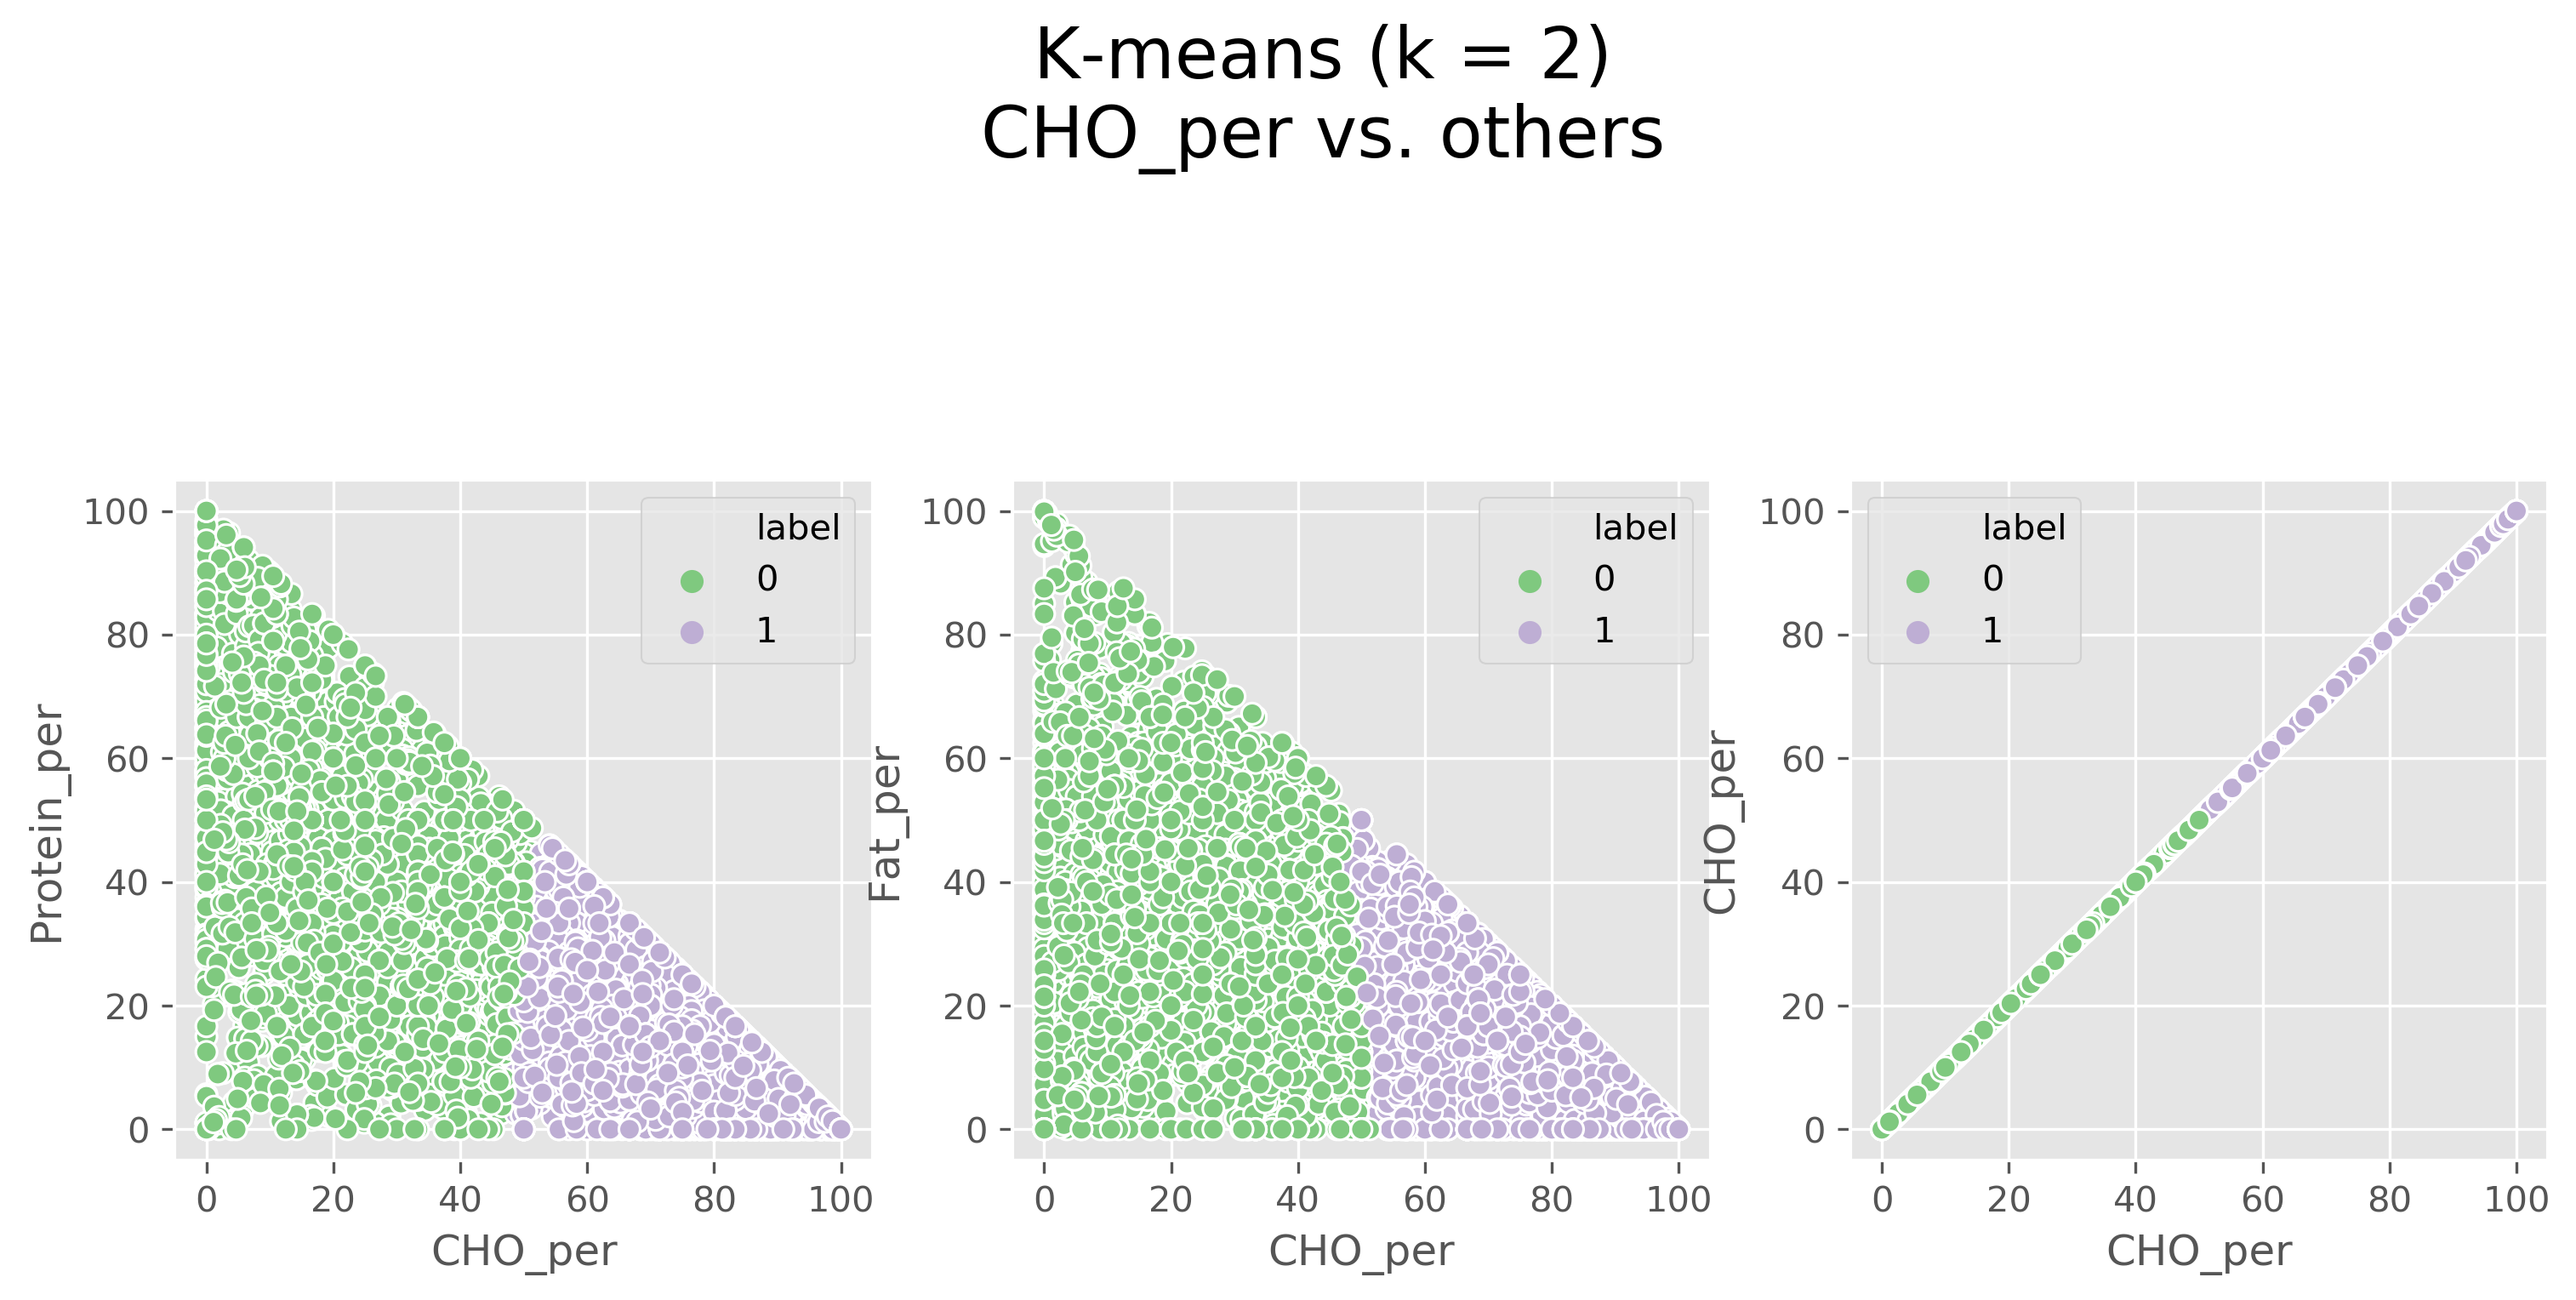

In [22]:
##CHO_per vs. others

title = 'CHO_per' 

a = "Protein_per"
b = "Fat_per"
c = "CHO_per"

# 制訂畫布
plt.figure(num=None, figsize=(12, 12), dpi=300, facecolor='w', edgecolor='k')

# 制訂畫布抬頭
plt.suptitle("K-means (k = " + str(k)+ ")" + ('\n') + title + ' vs. others', ha = 'center', va = 'bottom',
                 fontsize=20)

# 子圖
plt.subplot(3,3,1)
sns.scatterplot(x=dfi[title],
                y=dfi[a],
                hue=dfi["label"], palette="Accent")
 
plt.subplot(3,3,2)
sns.scatterplot(x=dfi[title],
                y=dfi[b],
                hue=dfi["label"], palette="Accent")
 
plt.subplot(3,3,3)
sns.scatterplot(x=dfi[title],
                y=dfi[c],
                hue=dfi["label"], palette="Accent")

# 儲存圖片
plt.savefig(path + Stand + '_' + "k" + str(k)  +  '_' + str(param)+'param' + '_' + str(title) + 'VsOthers' +'.png', dpi=300, bbox_inches = 'tight')
plt.show()

### 結論：本分群效果不佳